### DIABETES PIPELINE

In [1]:
################################################
# End-to-End Diabetes Machine Learning Pipeline II
################################################

import joblib
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

################################################
# Helper Functions
################################################

# Bu bölüm karşımıza helpers.py ya da utils.py şeklinde ilgili projenin çalışma dosyasında dışarıdan da denk gelebilir. Yani 
# burada machine learning içerisinde helper functions adından bir python dosyası olsaydı bunun içerisinde eğer bu fonksiyonlar
# olsaydı bunu da bu şekilde okuyabilirdik. Nasıl okurduk mesela from helpers import * ile hepsini okumayı, from helpers import
# a/b/c şeklinde okusaydık istediğimiz bir kısmını okurduk. Bunu bu şekilde yapmak ne getiri ne götürür. Kod okunuşu açısından
# daha temiz bir görüntü oluşur, utils ya da helpers adından bir isimlendirme ile bunu dışarıdan da buraya getirebiliriz. Biz 
# herkesin hata almadan kullanabilmesi için aşağıdaki gibi yapmayı tercih ettik. Çünkü dışarıdan çağırdığımızda bazılarımız 
# uygulayabilecekken bazılarımız uygulayamayacak.

# DİKKAT : Orta ileri seviyede data science kültürü oturmuş bir şirkete girdiğimizde proje dosyalarını okuyor olduğumuzda 
# utils.py gibi bir dosya görebiliriz, helpers.py şeklinde bir dosya görebiliriz. Bunlar içerisinde projenin ana scriptinde yer
# kaplamaması için ya da başka scriptler tarafından da kullanılabilecek fonksiyonları barındırdığından dolayı bu şekilde
# dışarıdan çağırılabilir dosyalar görebiliriz. Bunların içerisinde kullanacak olduğumuz fonksiyonlar vardır. Oraya koyduğumuz
# durumda buradaki görüntü kirliliğinden kurtuluyor oluruz.

# utils.py
# helpers.py

# Data Preprocessing & Feature Engineering
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def diabetes_data_prep(dataframe):
    dataframe.columns = [col.upper() for col in dataframe.columns]

    # Glucose
    dataframe['NEW_GLUCOSE_CAT'] = pd.cut(x=dataframe['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

    # Age
    dataframe.loc[(dataframe['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
    dataframe.loc[(dataframe['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

    # BMI
    dataframe['NEW_BMI_RANGE'] = pd.cut(x=dataframe['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                        labels=["underweight", "healty", "overweight", "obese"])

    # BloodPressure
    dataframe['NEW_BLOODPRESSURE'] = pd.cut(x=dataframe['BLOODPRESSURE'], bins=[-1, 79, 89, 123],
                                            labels=["normal", "hs1", "hs2"])

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

    replace_with_thresholds(df, "INSULIN")

    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)

    return X, y

# Base Models
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

# Hyperparameter Optimization

# config.py
# Mesela bu diyabet pipeline projesi kapsamında şöyle bir yaklaşım sergilenebilir. Mesela config.py adında bir konfigürasyon
# dosyası olur. Buraya örneğin veri setinin path'i konabilir, örneğin aşağıdaki parametrelerin bu bölümleri konabilir. Yani
# bu sözlükler bu config dosyasının içerisine konulabilir. Aslında konfigürasyon dediğimiz nasıl ki makine öğrenmesi 
# modellerinde hiperparametre dediğimiz ve dışarıdan bizim ayarladığımız ve değişkenlik gösteren bazı şeyler var. Bu şekildeki
# bir veri bilimi, pipeline, makine öğrenmesi proje sürecinde de dışarıdan ayarlanabilecek olan şeyleri bir konfigürasyon 
# dosyasına da koyabiliriz. Bu konfigürasyon dosyasına girerek orada değişiklikler yaparak ondan sonra ara scriptimizi 
# çalıştırdığımızda o değişikliklere göre ilerlemesini sağlayabiliriz. Bu oldukça önemli bir konudur, tercih edilebilir ancak
# biz burada tercih etmiyoruz. Birkaç örnek daha verelim: Mesela verinin okunma kaynağı, modelin yazılacağı kaynak, elde edilen
# hiperparametreleri kaydetmek istiyorsak onların kaydedileceği kaynak, pathleri/dizinleri ifade ediyoruz onlar buraya 
# girilebilir. output_path dşye buraya bir string nesne oluşturulur ve buraya saklanabilir. Aşağıdaki parametrelerin hepsi
# oraya girilebilir. Daha sonra nerden okuyacağız bunu? Az önceki okuma yöntemine benzer bir şekilde from kullanarak okunabilir.
# Başka örnek vermek gerekirse bir loglama yapılabilir. Yani çeşitli iterasyonlarda elde edilen sonuçlar biz sadece ekrana 
# bastırdık, bunların bir log'u, geçmişi tutulabilir. 

knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

# Stacking & Ensemble Learning
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]), ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)
    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

In [2]:
# Şimdi öyle birişlem yapmamız lazım ki örneğin bu python scriptini bir proje dosyası gibi bir sunucu ortamında ya da kişisel
# bir bilgisayarda iişletim sistemi seviyesinden çalıştırabiliyor olmalıyız. Dolayısıyla bu bölümdeki amacımız bu pipeline
# sürecini daha iyi anlamaya çalışmak ve süreci tamamlamak.

# DİKKAT : Pipeline konusu iş aldıran serisinden çok değerli bir konudur. Online bir eğitimde böyle bir süreci kabul edilebilir
# bir kapsayıcılıkta deneyimleyebiliyor olmak oldukça değerlidir. Günün sonunda pipeline dediğimiz şey budur.


################################################
# Pipeline Main/Run Function
################################################

def main():
    
    # Burada bir veri okuma işlemi vardır. Bu bir csv dosyasından olmaz da daha çok veri tabanlarından olur. Veri tabanından 
    # veriyi çek. Pipeline'ın boru hattının ilk aşamasıdır. 
    df = pd.read_csv("datasets/diabetes.csv")
    
    # Daha sonra çekmiş olduğumuz veriyi veri ön işleme scriptinden geçiriyoruz. Bu Pipeline'ın 2.aşamasıdır.
    X, y = diabetes_data_prep(df)
    
    # 3.adım genel modellere bakmaktır. Bunu buraya koymayabiliriz de bu kısım daha çok research kısmına özeldir. Ancak bir 
    # görelim düşüncesiyle buraya koyduk.
    base_models(X, y)
    
    # Bir sonraki adım hiperparametre optimizasyonudur.
    best_models = hyperparameter_optimization(X, y)
    
    # Yukarıdan gelen en iyi modellerle bir voting classifier oluşturuyoruz:
    voting_clf = voting_classifier(best_models, X, y)
    
    # Model nesnesini bir yere kaydediyoruz. Bu şekilde bir train sürecini bir pipeline aracılığıyla tamamlamış olduk. 
    joblib.dump(voting_clf, "voting_clf.pkl")
    
    return voting_clf
# Burada voting_clf kullanmayacağımızdan dolayı return etmemeyi tercih edebiliriz. Biz şu anda bir tarining sürecini planladık. 
# Yani bir pipeline'ın amacı uçtan uca çeşitli basamaklardaki veri ön işlemeleri ve benzeri görevleri yerine getirerek 
# classifier nesnesini dışarıya pkl dosyası olarak kaydetmektir. Bu pkl dosyasını daha sonra farklı bir kodun içerisinde 
# çalıştırabilir, çağırabilir ve kullanabiliriz. Dolayısıyla bu ana görev kapsamında bu training scriptinde bu voting_clf'ı
# çalıştırılmayacağından dolayı bunu return etmeyebiliriz de, bu da iyi bir tercih olabilir.

In [4]:
if __name__ == "__main__":
    print("İşlem başladı")
    main()

# Bunu pycharm üzerinden de yap. O zaman if'in yanında bir play tuşu çıkacak, ona basarak işini halledebilirsin.

# git github
# makefile
# veri tabanlarından
# log
# class
# docker
# requirement.txt

İşlem başladı
Base Models....
roc_auc: 0.8409 (LR) 
roc_auc: 0.791 (KNN) 
roc_auc: 0.8355 (SVC) 
roc_auc: 0.658 (CART) 
roc_auc: 0.8198 (RF) 
roc_auc: 0.8196 (Adaboost) 
roc_auc: 0.8263 (GBM) 
roc_auc: 0.8015 (XGBoost) 
roc_auc: 0.807 (LightGBM) 
Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.791
roc_auc (After): 0.8211
KNN best params: {'n_neighbors': 20}

########## CART ##########
roc_auc (Before): 0.6575
roc_auc (After): 0.7943
CART best params: {'max_depth': 6, 'min_samples_split': 23}

########## RF ##########
roc_auc (Before): 0.8301
roc_auc (After): 0.834
RF best params: {'max_depth': 8, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 200}

########## XGBoost ##########
roc_auc (Before): 0.8015
roc_auc (After): 0.8255
XGBoost best params: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

########## LightGBM ##########
roc_auc (Before): 0.807
roc_auc (After): 0.8234
LightGBM best params: {'colsample_b

**DİKKAT :** Yukarıdaki ifadeye dunder name dunder main denir. Yani double under score'dur. Eğer ortasında name varsa dunder name diye, ortasında main varsa dunder main diye okunur. 

if __name__ == "__main__":
    main()

Bloğu der ki eğer çalıştırılabilir bir nesne varsa o zaman bu işi yap der ve main fonksiyonunu çağırır. Yani fonksiyon isimlendirmesinde main yazdığımızdan dolayı ve burada maini sorguluyor gibi gözüktüğümüzden dolayı bu çalışmaz. Herhangi yukarıda import işlemi tanımlama işlemi gibi bazı işlemler varsa bu durumda dunder name dunder main bloğu çalışır ve if __name__ == "__main__" kısmı sağlanıyorsa bunu yap ( main() ) dendiğindeki görev burada çalışmaya başlar. 

**İyi de neden böyle yapıyoruz. Yukarıdaki fonksiyonların hepsini seçip çalıştırırız.**
Problem şudur ki bunu komut satırından çalıştırmak istediğimizde kodumuzun içine girip çalıştırması görevini görmesi açısından yukarıdaki şekilde dunder name dunder main olarak yapmalıyız.

Bunun temel kullanılma amacı bir script'i bir python dosyasını aslında tetikleyici bölümdür. Bir python dosyasını çalıştıracak olan nihai bölümdür. Biz bunu işletim sistemi seviyesinden bu scripti çalıştırdığımızda tanımlandı tanımlandı ee bu da tanımlandı. Buraya bir kontrol mekanizması koyalım da burası onu çalıştıracak bölüm olsun diye düşünürüz ve bu bölüm aracılığıyla kod çalışır. Bunu yazmasak da çalışır aslında fakat burada execution işlemi başlamadan önce bu nokta bize çeşitli dokunuşlar gerçekleştirme imkanı sağlar. İçine print ile işlem başladı kodunu eklersek. İlk çalışacak kısım dunder name dunder main bloğudur. Doğru ise çalışma başlatılır. main'i başlatmadan önce dolayısıyla print yazdığımız yere bir rapor ekleyebiliriz. Sadece bu mu hayır buraya timer fonksiyonları atayabiliriz. Yani çeşitli görevlerin ne kadar sürdüğünü hesaplama işlemleri yapabiliriz. Mesela cli ekleyebiliriz. Yani comment line interface ekleyebiliriz. Bunları da burada çeşitli etkileşimlere sokabiliriz. Yani eğer işletim sistemi seviyesinden bu kodu çalıştıran bir kişi bir argüman girdiyse yani dışarıdan bu scriptin içerisini biçimlendirmek değiştirmek istiyorsa bu değiştirme biçimlendirme işlemini bu ilk run olacak (dunder name dunder main kısmında) bölümde şekillendirebiliriz. Dolayısıyla bu gibi birçok amaçla kullanılabilir. Özetle bizim aklımızda tutmamız gereken nokta bir python scriptini işletim sistemi seviyesinden yani komut satırı seviyesinden run etmek istediğimizde böyle bir blok ekleyerek gerçekleştirebiliriz olmalıdır. 


if __name__ == "__main__": bloğu devreye girecektir. eğer içe aktarılmışsa bu blok çalıştırılmayacak ve __name __, sizin betiğe verdiğiniz isim olarak geçecektir. 

if __name__ == "__main__":
    print("Eğer doğrudan çalıştırılmışsam beni görürsünüz.")
    print(__name__)

else:
    print("Beni yalnızca içe aktardığınızda görebilirsiniz.")
    print(__name__)
    



**Komut satırında çalıştırılması:**

Bunu komut satırından önce python'ı çağırarak ondan sonra bu scripti çağırarak gerçekleştirmek istiyoruz.Proje bölümüne geldik. Bu dosyamız her neredeyse o dosyanın olduğu dizine gelmeliyiz. Eğer programı en başlarından beri hoca ile takip ediyorsak şu anda çalışma dizinimizin içerisinde olmamız gerekir. Dosyada sağa tık yapıp Open In Terminal diyoruz. Bu terminal şu anda bizim içerisinde çalıştığımız çalışma dizinidir. Dosyamızın bu çalışma dizininin içinde olması lazım. Bu çalışma dizininin altındaysa python diabetes_pipeline.py dediğimizde çalışması gerekir. diabetes_pipeline.py hangi dosya altındaysa onda terminali açıyoruz.

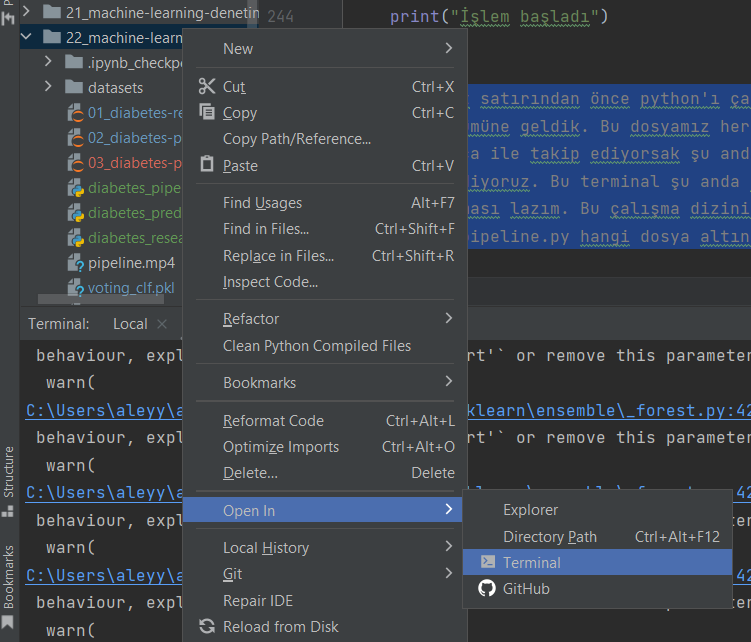

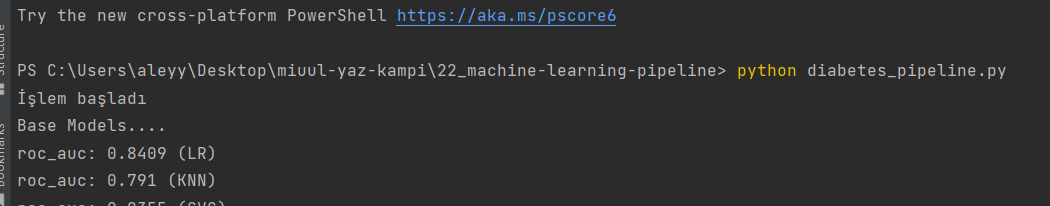

Şu anda terminal/komut satırından işletim sistemi seviyesinde bir makine öğrenmesi projesini çalıştırdık. Bu işin en core en temel noktasıdır. Burada hazırlamış olduğumuz bu pipeline bunun dışında kalan işlerin en önemli kısmı ve kalbidir. Dolayısıyla profesyonel yaşantımızda bir proje kapsamındaburaya eklenmesi gereken diğer bazı şeyler de olacaktır. Ama temel odak ve pekişmesi gereken nokta burasıdır.

Peki hangi bileşenler lazım gibi bir soru olabilir. Ne tür işlemlerle karşılaşabiliriz gibi bir soru olabilir. Daha öncesinde bir kısmından bahsetmiştik. Şimdi bunları biraz ele alalım.

1 - git github entegrasyonuyla bu iş gitmelidir. Burada veri bilimş ve makine öğrenmesi işleri için git etkileşimlerinin normal bir yazılım geliştirme sürecine göre daha düşük olabileceğini söyleyebiliriz ve riskin biraz daha düşük olduğunu, kullanım frekansının biraz daha düşük olduğunu söyleyebiliriz. Bu kullanıp kullanmamakla ilgili değil kullanma esnasındaki kullanım frekansını ifade ediyoruz.

2 - makefile gibi otomasyon tooları tercih edilebilir. Bu makefile'ın python versiyonu da vardır. Daha kolaylaştırılmış bir versiyonudur. Nedir makefile? Biz bu projeye bir komut satırı arayüzü yazmadık. Yani işletim sistemi seviyesinden komutlar vererek bu içerideki scripti biçimlendirebilecek işlemler yapmadık. Buna benzer işlemleri git igthub işlemlerini veya çeşitli görevleri makefile kod otomasyon aracıyla yapabiliriz. Mesela örnek olması için terminalde make git dediğimizde sadece örneğin bir git add commit ve push işlemlerini peş peşe yaptırabiliriz. Makefile bir kod otomasyonu, linux aracıdır. Burada örneğin make git kısayoluna git add git commit ve git push gibi 3 4 tane işlemi ekleyip bu şekilde bir kısayolla işlemleri otomatize edebiliriz. Ya da örnek olması için bir makefile içrisinde make train diye bir şey oluştururuz, bu make train'in içerisinde az önce yapmış olduğumuz  python diabetes_pipeline.py kodu olur. Bunu make train şeklinde daha kısa bir şekilde ifade ederek bu işlemi çalıştırabiliriz. Yani özetle ifade etmek gerekirse bu komut satırında uzun olabilecek bazı kod yazımlarını daha pratik daha kısa bir şekilde peş peşe de çeşitli kodları çalıştırabilecek şekilde yapabileceğimiz bir yapıdır makefile.

3 - veri tabanlarından veri okunuyor olacak. Veri tabanından veri okumak da oldukça kolaydır. Bağlantı bilgileri neticesinde bağlantıyı gerçekleştirip daha sonra tekrar o tabloları geriye basacak şekilde kullanımlar değerlendiriliyor olunur.

4 - log : Süreçlerin logunu tutmak olabilir.

5 - class : Fonksiyonları class yapılarına çevirmek olabilir.

6 - docker : Benim bilgisayarım da çalışıyordu, sunucuda çalışmıyor ifadesinden hatırlayabiliriz. Ortak bir işletme process'i, ortak bir işletme prosedürü çerçevesinde dockerize edilmiş projeler docker barındıran tüm ortamlarda ilk oluşturdukları ortamdaki gibi çalışabilmektedir. Dolayısıyla buradaki dependency management problemlerini, gereklilikleri ve benzeri noktaları daha iyi proje kapsamında taşıyabilmek için bir docker işlemine sokulabilir.

7 - requirement.txt 

**Toparlayacak olursak uçtan uca diyabet projemizi önce research anlamında, notebook anlamında, üzerinde çalışma, karar verme anlamında bir dosya üzerinde geliştirip kararlarımızı verdik, notlarımızı düştük, dikkat edilmesi gereken noktaları da ifade ettik. Olayı artık önceki gibi bir jupyter notebook'da çalışıyor gibi değil de ölçeklenebilirlik ihtiyaçlarına yanıt verebilecek genellenebilir fonksiyonel bir tarzda yanıt vermeye çalıştık. Buna yöneli olarak ilgili fonksiyonlarımızı oluşturduk. Artık yukarıdaki şekilde komut satırından çalıştırma işlemini gerçekleştirdiğimizde modeller raporlanmalarıyla ve nihai model çıktısıyla beraber önümüze gelmektedir.**